## TODO:

- compute the lj potential and the total energy
- compute momenta
- tuning of parameters and unit of measure
- plot the energies
- plot the trajectoires (chose a particle, chose a timestep)

BONUS:
- make a gif of the simulation
- make a slicer for the dt
- make a slicer for the particle and plot position, velocity and acceleration of that particle

CONSIDERATIONS:
- if we use an high epsilon the partices will be trapped in a local minima and they will form particluar shapes
- pay attention to the timestep

In [60]:
import os
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.constants import Boltzmann

In [65]:
# TODO: put constants in a json file
DT = 0.01 # ps
MAX_DISTANCE = 50 # angstrom
TOTAL_PARTICLES = 100
MAX_TIME_STEPS = 100
MASS = 39.95 # argon amu
TEMPERATURE = 300 # K
EPSILON = 0.0105 # eV
SIGMA = 3.44 # angstrom
CUTOFF = 15 # angstrom

PRECISION = 3

## Useful functions

In [68]:
def initial_conditions(
    particles_number,
    temperature,
    max_distance,
    mass
):
    result = {}
    for key in range(particles_number):
        result[key] = {
            'position': [init_position(max_distance)],
            'velocity': [init_velocity(temperature, mass)]
        }
    for key in result.keys():
        result[key]['acceleration'] = [update_acceleration(key, result)]
    return result


def init_position(max_distance):
    return np.random.uniform(-max_distance, max_distance, size=3)


def init_velocity(temperature, mass):
    return (np.random.rand(3) - 0.5) * np.sqrt(Boltzmann * temperature / (mass * 1.602e-19))


def init_acceleration():
    return np.full(3, 0.01)

# --------------------------------------------------------------------------------------------------------------------

def update_conditions(sample, new_conditions):
    for key in sample.keys():
        for observable, value in new_conditions[key].items():
            sample[key][observable].append(value)


# TODO: pass the new positions and not the current in the accelerations get
def get_new_conditions(sample, time):
    result = {}
    for key, particle in sample.items():
        result[key] = {}
        result[key]['position'] = update_position(time, particle)
        result[key]['acceleration'] = update_acceleration(key, sample)
        result[key]['velocity'] = update_velocity(time, particle['velocity'][-1], [particle['acceleration'][-1], result[key]['acceleration']])
    return result


def update_position(time, particle):
    return particle['position'][-1] + particle['velocity'][-1]*time + 0.5*particle['acceleration'][-1]*time**2


def update_velocity(time, velocty, accelaretion: list):
    ''' Verlet velocity algorithm: mean is applied to acceleration to compensate discretized error '''
    return velocty + np.mean(accelaretion)*time


def update_acceleration(index, sample):
    positions = [particle['position'][-1] for particle in sample.values()]
    accelerations = []
    for i in range(len(positions)):
        if i == index:
            continue
        position_differences = positions[index] - positions[i]
        forces = lj_forces(abs(position_differences), EPSILON, SIGMA)
        accelerations.append([
            (position_difference/np.sqrt(position_difference**2)) * forces[n] / MASS
            if position_difference != 0 else 0
            for n, position_difference in enumerate(position_differences)
        ])
    return np.sum(accelerations, axis=0)

# --------------------------------------------------------------------------------------------------------------------

def lj_potential(positions, epsilon, sigma):
    pass


# TODO: check the if condition
def lj_forces(positions, epsilon, sigma):
    '''   
        Parameters
        ----------
        r: float
            Distance between two particles (Å)
        epsilon: float 
            Potential energy at the equilibrium bond 
            length (eV)
        sigma: float 
            Distance at which the potential energy is 
            zero (Å)
    '''
    return [
        48 * epsilon * np.power(sigma, 12) / np.power(position, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(position, 7)
        if position < CUTOFF and position != 0 else 0
        for position in positions
    ]


def get_kinetic_energy(velocity):
    return 0.5*MASS*velocity**2


def apply_elastic_collision(particle1, particle2):
    particle1['velocity'] = compute_sign(particle1['velocity'], particle2['velocity']) * particle1['velocity']
    return particle1


def check_positions(new_conditions):
    
    for key, particle in new_conditions.items():
        sign_factor = compute_sign(particle['position'][abs(particle['position']) >= MAX_DISTANCE], 1)
        particle['velocity'][abs(particle['position']) >= MAX_DISTANCE] = -particle['velocity'][abs(particle['position']) >= MAX_DISTANCE]
        particle['position'][abs(particle['position']) >= MAX_DISTANCE] = sign_factor*MAX_DISTANCE 
        # particle['position'][abs(particle['position']) >= MAX_DISTANCE] = particle['position'][abs(particle['position']) >= MAX_DISTANCE] - sign_factor*MAX_DISTANCE 

    for key2, particle2 in new_conditions.items():
        particle = apply_elastic_collision(particle, particle2) if all(particle['position'] == particle2['position']) and key != key2 else particle
    new_conditions[key] = particle

    return new_conditions


def compute_sign(vector1, vector2):
    return np.sign(vector1*vector2)

## Dynamics

In [69]:
sample = initial_conditions(TOTAL_PARTICLES, TEMPERATURE, MAX_DISTANCE, MASS)

# TODO: add energy computation
# TODO: compute momenta
for time in tqdm(range(MAX_TIME_STEPS)):
    new_conditions = get_new_conditions(sample, DT)
    new_conditions = check_positions(new_conditions)
    update_conditions(sample, new_conditions)
    #print(time, '\n', sample)

100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


## Plots

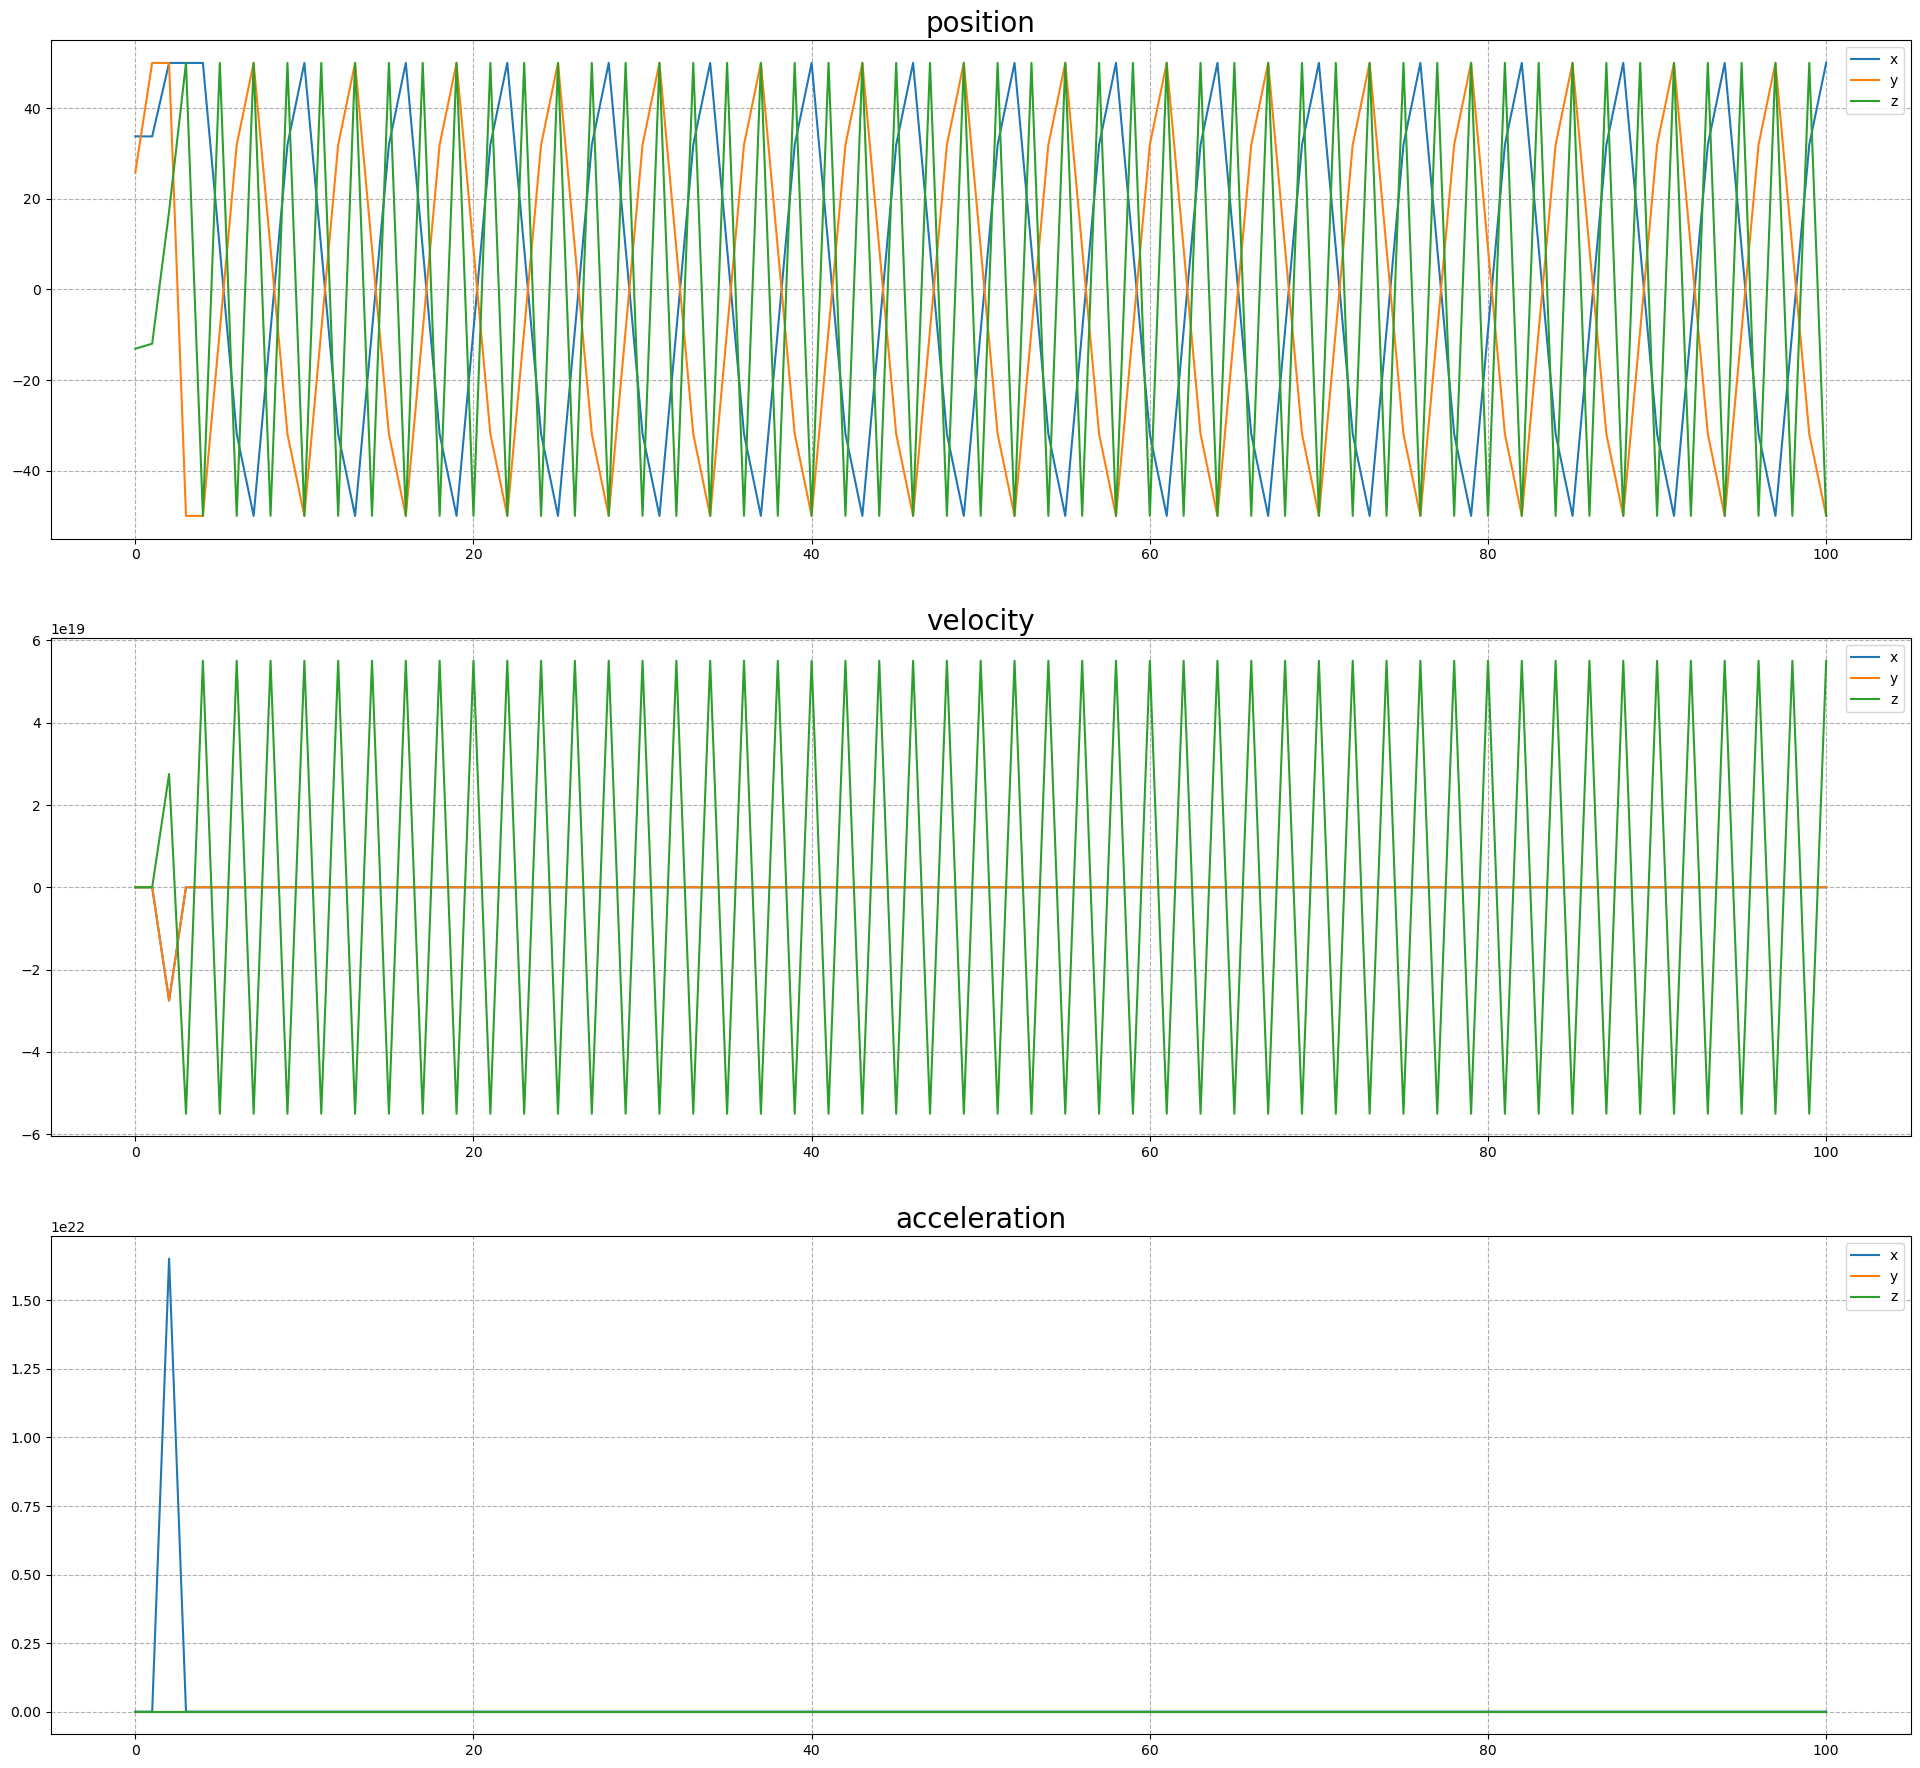

In [70]:
plt.figure(figsize=(24,22))
particle_number = 1

plt.subplot(3,1,1)
plt.plot(np.array(sample[particle_number]['position'])[:,0], label='x')
plt.plot(np.array(sample[particle_number]['position'])[:,1], label='y')
plt.plot(np.array(sample[particle_number]['position'])[:,2], label='z')
plt.title('position', fontsize=20)
plt.grid(linestyle='--')
plt.legend()

plt.subplot(3,1,2)
plt.plot(np.array(sample[particle_number]['velocity'])[:,0], label='x')
plt.plot(np.array(sample[particle_number]['velocity'])[:,1], label='y')
plt.plot(np.array(sample[particle_number]['velocity'])[:,2], label='z')
plt.title('velocity', fontsize=20)
plt.grid(linestyle='--')
plt.legend()

plt.subplot(3,1,3)
plt.plot(np.array(sample[particle_number]['acceleration'])[:,0], label='x')
plt.plot(np.array(sample[particle_number]['acceleration'])[:,1], label='y')
plt.plot(np.array(sample[particle_number]['acceleration'])[:,2], label='z')
plt.title('acceleration', fontsize=20)
plt.grid(linestyle='--')
plt.legend()

plt.show()

In [59]:
timestep = 0
for timestep in tqdm(range(MAX_TIME_STEPS)):

    x_positions = np.array([particle['position'][timestep][0] for particle in sample.values()])
    y_positions = np.array([particle['position'][timestep][1] for particle in sample.values()])
    z_positions = np.array([particle['position'][timestep][2] for particle in sample.values()])

    fig = plt.figure(figsize=(24,7))
    fig.suptitle('Timestep: {}'.format(timestep), fontsize=25)
    
    plt.subplot(1,3,1)
    plt.scatter(x_positions, y_positions, label='xy', cmap='turbo', c=x_positions)
    plt.title('xy', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.subplot(1,3,2)
    plt.scatter(x_positions, z_positions, label='xz', cmap='turbo', c=x_positions)
    plt.title('xz', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.subplot(1,3,3)
    plt.scatter(y_positions, z_positions, label='yz', cmap='turbo', c=x_positions)
    plt.title('yz', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.savefig('./figures/' + str(timestep) + '.png')
    # plt.show()
    plt.close()

files = os.listdir('./figures')
with imageio.get_writer('simulation2.gif', mode='I') as writer:
    for filename in tqdm(files):
        image = imageio.imread('./figures/'+ filename)
        writer.append_data(image)

for filename in set(files):
    os.remove('./figures/'+ filename)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_42719/3205337759.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('./figures/'+ filename)
100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


In [34]:
filenames = []
n_frames = 10
for timestep in tqdm(range(MAX_TIME_STEPS - 1)):

    x = np.array([particle['position'][timestep][0] for particle in sample.values()])
    y = np.array([particle['position'][timestep][1] for particle in sample.values()])
    z = np.array([particle['position'][timestep][2] for particle in sample.values()])
    
    x1 = np.array([particle['position'][timestep+1][0] for particle in sample.values()])
    y1 = np.array([particle['position'][timestep+1][1] for particle in sample.values()])
    z1 = np.array([particle['position'][timestep+1][2] for particle in sample.values()])

    while len(x) < len(x1):
        diff = len(x1) - len(x)
        x = x + x[:diff]
        y = y + y[:diff]
        z = z + z[:diff]
    while len(x1) < len(x):
        diff = len(x) - len(x1)
        x1 = x1 + x1[:diff]
        y1 = y1 + y1[:diff]
        z1 = z1 + z1[:diff]

    x_path = np.array(x1) - np.array(x)
    y_path = np.array(y1) - np.array(y)
    z_path = np.array(z1) - np.array(z)
    for i in np.arange(0, n_frames + 1):                

        x_temp = (x + (x_path / n_frames) * i)
        y_temp = (y + (y_path / n_frames) * i)
        z_temp = (z + (z_path / n_frames) * i)
        
        fig = plt.figure(figsize=(24,7))
        fig.suptitle('Timestep: {}'.format(timestep), fontsize=25)
        
        plt.subplot(1,3,1)
        plt.scatter(x_temp, y_temp, label='xy', cmap='turbo', c=x_temp)
        plt.title('xy', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

        plt.subplot(1,3,2)
        plt.scatter(x_temp, z_temp, label='xz', cmap='turbo', c=x_temp)
        plt.title('xz', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

        plt.subplot(1,3,3)
        plt.scatter(y_temp, z_temp, label='yz', cmap='turbo', c=x_temp)
        plt.title('yz', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)


        filename = f'./figures/frame_{timestep}_{i}.png'
        filenames.append(filename)
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)

        plt.savefig(filename, dpi=96)
        plt.close()



files = os.listdir('./figures')
with imageio.get_writer('simulation.gif', mode='I') as writer:
    for filename in files:
        image = imageio.imread('./figures/'+ filename)
        writer.append_data(image)

for filename in set(files):
    os.remove('./figures/'+ filename)

100%|██████████| 99/99 [03:46<00:00,  2.28s/it]
/tmp/ipykernel_42719/1919209224.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('./figures/'+ filename)


## Test

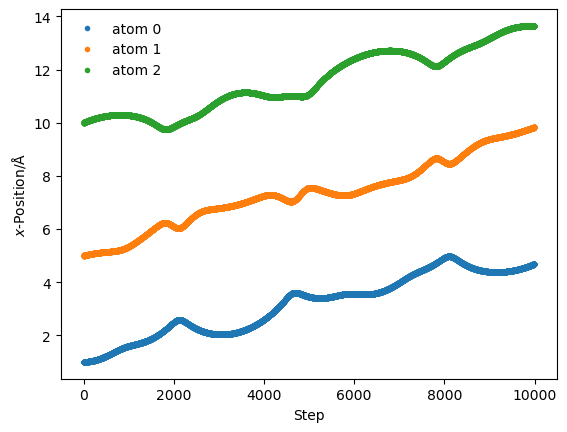

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann
mass_of_argon = 39.948 # amu

def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma, 12) / np.power(
        r, 13) - 24 * epsilon * np.power(
        sigma, 6) / np.power(r, 7)

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of 
    particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at 
        initialisation (K)
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of 
        particles (eVs/Åamu)
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / (
        mass_of_argon * 1.602e-19))

def get_accelerations(positions):
    """
    Calculate the acceleration on each particle
    as a  result of each other particle. 
    N.B. We use the Python convention of 
    numbering from 0.
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, 
        for all of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each
        particle (eV/Åamu)
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 0.0103, 3.4)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon
            accel_x[j, i] = - force_x / mass_of_argon
    return np.sum(accel_x, axis=0)

def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a 
        single dimension
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single 
        dimension
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension at the previous 
        timestep (eV/Åamu)
    a1: ndarray of floats
        The accelerations of the particles in a
        single dimension at the current 
        timestep (eV/Åamu)
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a
        single dimension (eVs/Åamu)
    """
    return v + 0.5 * (a + a1) * dt

def run_md(dt, number_of_steps, initial_temp, x):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt)
        a1 = get_accelerations(x)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

x = np.array([1, 5, 10])
sim_pos = run_md(0.1, 10000, 300, x)
    
%matplotlib inline
for i in range(sim_pos.shape[1]):
    plt.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
plt.xlabel(r'Step')
plt.ylabel(r'$x$-Position/Å')
plt.legend(frameon=False)
plt.show()